In [1]:
from PIL import Image
import numpy as np
import os, glob, itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import keras
from keras.models import Model
from keras.models import Sequential, model_from_json
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from keras.utils import multi_gpu_model
from keras.applications.resnet50 import ResNet50
from keras import optimizers
#from keras.applications.inception_resnet_v2 import InceptionResNetV2
#from keras.applications.densenet import DenseNet201
#from keras.applications.inception_v3 import InceptionV3
import csv
import cv2 as cv

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
def parse_filenames(folder_name):
    files = glob.glob(os.path.join("./", folder_name, '*.tif'))
    return files

def get_data(filenames):
    # Read from CSV file, find abbreviated label (alabel) to full label (flabel) mapping
    csv_rows = []
    with open("PLANTS.csv", 'rtU') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',', dialect=csv.excel_tab)
        for row in csvreader:
            csv_rows.append(row)

    for col_idx, col_title in enumerate(csv_rows[1]):
        if "PLPRMFL" in col_title:
            abbr_idx = col_idx
        if "PLFUELCT" in col_title:
            full_idx = col_idx
        if "Imagery Status" in col_title:
            imagery_idx = col_idx

    dict_alabel_flabel = {}
    dict_flabel_id = {}
    dict_alabel_id = {}
    dict_id_flabel = {}
    flabel_id_count = 0

    for row in csv_rows:
        if "YES" in row[imagery_idx]:
            if row[full_idx] not in dict_flabel_id:
                dict_flabel_id[row[full_idx]] = flabel_id_count
                dict_id_flabel[flabel_id_count] = row[full_idx]
                flabel_id_count += 1
            if row[abbr_idx] not in dict_alabel_flabel:
                dict_alabel_flabel[row[abbr_idx]] = row[full_idx]
                dict_alabel_id[row[abbr_idx]] = dict_flabel_id[row[full_idx]]
    print(dict_alabel_flabel)
    print(dict_flabel_id)

    m = len(filenames)
    X = np.zeros((m, 300, 300, 3))
    Y = np.zeros((m))
    dict_id_count = {}
    dict_flabel_count = {}

    for i in range(m):
        img = Image.open(filenames[i])
        X[i] = np.array(img)[:300,:300,:3]

        alabel = filenames[i].split('_')[-1][:-4]
        if (alabel not in dict_alabel_flabel):
            print("WARNING: unseen a-label found in filename.")
        Y[i] = int(dict_alabel_id[alabel])
        if (Y[i] not in dict_id_count):
            dict_id_count[Y[i]] = 0
        dict_id_count[Y[i]] += 1
        dict_flabel_count[dict_id_flabel[Y[i]]] = dict_id_count[Y[i]]

    print(X.shape)
    print(dict_id_count)
    print(dict_flabel_count)
    print(sorted(((v,k) for k,v in dict_flabel_count.items()), reverse=True))
    print(np.histogram(Y))
    return X, Y, dict_id_flabel

def resize_image(X, size):
    X_new = np.zeros((X.shape[0], *size, 3))
    for i in range(X.shape[0]):
        X_new[i, :, :, :] = cv.resize(X[i, :, :, :], 
                                      size, interpolation=cv.INTER_LINEAR)
    return X_new

def plot_history(history):
    '''
    Plots train and val loss and accuracy given history. From: history = model.fit(...)
    '''
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    :param cm: a confusion matrix output from sklearn func, which takes on actual label and prediction
    :param classes: a list of all the labels
    :param normalize: if True, performs row normalization
    :param title: title of the plot
    :param cmap: color choices
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('Power Plant Classification Confusion Matrix.png')

In [5]:
#os.chdir('drive/Colab Notebooks')
os.getcwd()

'/home/Jerry/cs231n_power_plant'

In [6]:
np.random.seed(7)

# Load images
X_raw, Y_raw, dict_id_flabel = get_data(parse_filenames(folder_name='uspp_naip_resized'))

# Resize images
#X = resize_image(X_raw, size=(300, 300))
X = X_raw

# Convert labels into one-hot-encoding format
encoder = LabelBinarizer()
Y = encoder.fit_transform(Y_raw)

# Split into train, dev, and test set
x_traindev, x_test, y_traindev, y_test = train_test_split(X, Y,
                                                          test_size=0.1,
                                                          shuffle=True)
x_train, x_dev, y_train, y_dev = train_test_split(x_traindev, y_traindev,
                                                          test_size=0.1,
                                                          shuffle=True)

/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 'U' mode is deprecated
  


{'COG': 'COAL', 'BLQ': 'BIOMASS', 'DFO': 'OIL', 'BIT': 'COAL', 'NG': 'GAS', 'WH': 'OTHF', 'WAT': 'HYDRO', 'NUC': 'NUCLEAR', 'WDS': 'BIOMASS', 'SUB': 'COAL', 'OBS': 'BIOMASS', 'LFG': 'BIOMASS', 'SUN': 'SOLAR', '': '', 'WND': 'WIND', 'OTH': 'OTHF', 'GEO': 'GEOTHERMAL', 'OG': 'OFSL', 'PUR': 'OTHF', 'OBG': 'BIOMASS', 'MSW': 'BIOMASS', 'PRG': 'OTHF', 'MWH': 'OTHF', 'AB': 'BIOMASS', 'KER': 'OIL', 'RFO': 'OIL', 'PC': 'OIL', 'BFG': 'OFSL', 'SGC': 'COAL', 'LIG': 'COAL', 'WC': 'COAL', 'SLW': 'BIOMASS', 'WDL': 'BIOMASS'}
{'COAL': 0, 'BIOMASS': 1, 'OIL': 2, 'GAS': 3, 'OTHF': 4, 'HYDRO': 5, 'NUCLEAR': 6, 'SOLAR': 7, '': 8, 'WIND': 9, 'GEOTHERMAL': 10, 'OFSL': 11}
(4454, 300, 300, 3)
{5.0: 688, 9.0: 457, 2.0: 326, 8.0: 19, 7.0: 850, 3.0: 1160, 0.0: 357, 1.0: 427, 6.0: 46, 10.0: 59, 4.0: 53, 11.0: 12}
{'HYDRO': 688, 'WIND': 457, 'OIL': 326, '': 19, 'SOLAR': 850, 'GAS': 1160, 'COAL': 357, 'BIOMASS': 427, 'NUCLEAR': 46, 'GEOTHERMAL': 59, 'OTHF': 53, 'OFSL': 12}
[(1160, 'GAS'), (850, 'SOLAR'), (688, 'HY

## ResNet-50 Using Randomized Weights (All weights trainable)

In [7]:
def run_resnet50(x_train, y_train, x_dev, y_dev, epochs=50, batch_size=200):
    # Create base model:ResNet50
    M, H, W, C = x_train.shape
    base_model = ResNet50(weights=None, include_top=False, input_shape=(H, W, C))
    
    # Add modification in the last few layers
    x = base_model.output
    x = Flatten()(x)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(y_train.shape[1], activation='softmax')(x)
    
    # Create 'Model'
    model = Model(inputs=base_model.input, outputs=outputs)
    
    # Set trainable layers
    for layer in base_model.layers:
        layer.trainable = True
    
    opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    history = model.fit(x_train, y_train,
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_dev, y_dev))
    return model, history

In [8]:
# Run the model
model, history = run_resnet50(x_train, y_train, x_dev, y_dev, epochs=20, batch_size=30)

Train on 3607 samples, validate on 401 samples
Epoch 1/20
3607/3607 [==============================] - 213s 59ms/step - loss: 2.7370 - acc: 0.1758 - val_loss: 2.0867 - val_acc: 0.2868
Epoch 2/20
3607/3607 [==============================] - 187s 52ms/step - loss: 2.2322 - acc: 0.2357 - val_loss: 2.0383 - val_acc: 0.2718
Epoch 3/20
3607/3607 [==============================] - 187s 52ms/step - loss: 2.1418 - acc: 0.2490 - val_loss: 2.0294 - val_acc: 0.2469
Epoch 4/20
3607/3607 [==============================] - 187s 52ms/step - loss: 2.0928 - acc: 0.2670 - val_loss: 1.9690 - val_acc: 0.3292
Epoch 5/20
3607/3607 [==============================] - 187s 52ms/step - loss: 2.0466 - acc: 0.2864 - val_loss: 1.9756 - val_acc: 0.2868
Epoch 6/20
3607/3607 [==============================] - 187s 52ms/step - loss: 2.0167 - acc: 0.3052 - val_loss: 1.9559 - val_acc: 0.3242
Epoch 7/20
3607/3607 [==============================] - 188s 52ms/step - loss: 1.9747 - acc: 0.3252 - val_loss: 1.9214 - val_acc: 0

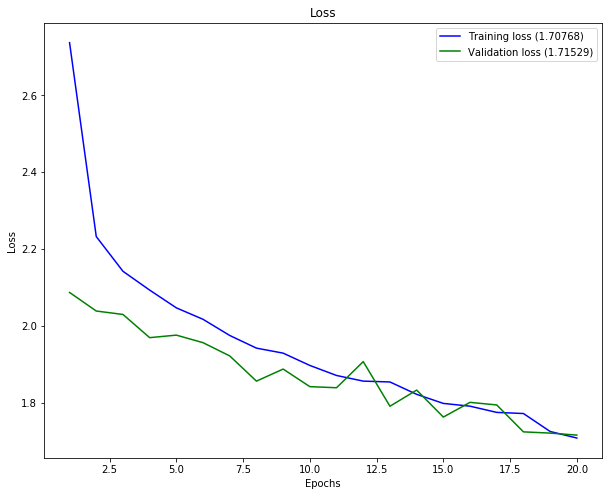

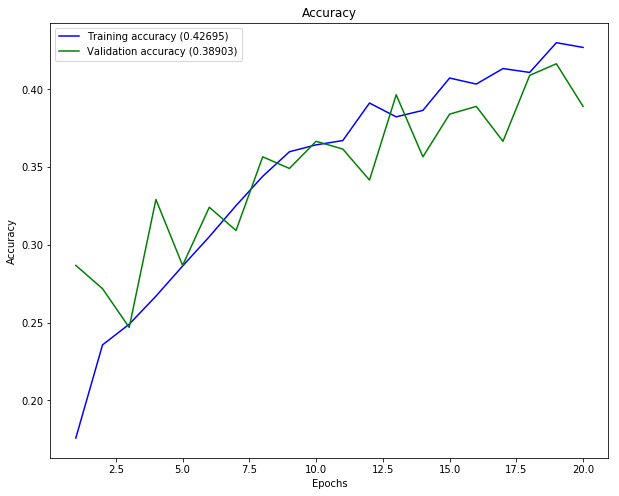

Confusion matrix
[[ 0  0  0 29  0  5  0  3  0  0  0  0]
 [ 0  0  0 29  0  4  0  7  0  1  0  0]
 [ 0  0  1 13  0 11  0  1  0  2  0  0]
 [ 0  0  0 97  0  9  0 11  0  1  0  0]
 [ 0  0  0  1  0  2  0  0  0  0  0  0]
 [ 0  0  0 23  0 54  0  4  0  1  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0 31  0  5  0 33  0  4  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0 10  0  3  0 14  0 26  0  0]
 [ 0  0  0  2  0  1  0  1  0  3  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0]]
Test Accuracy: 0.473094


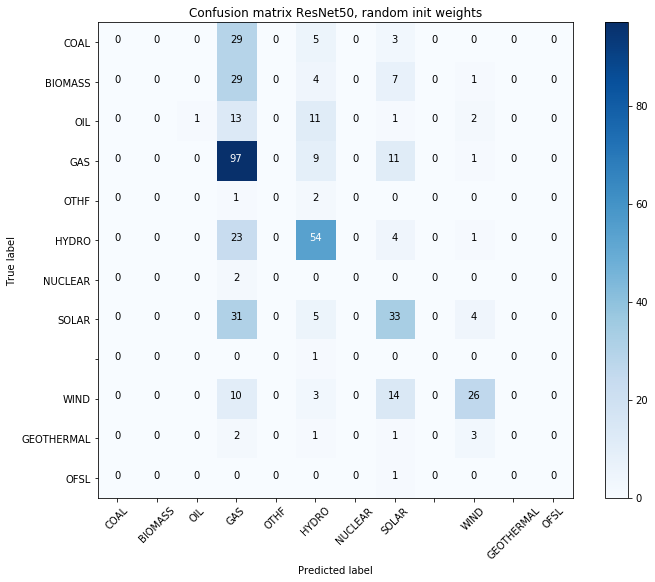

In [9]:
# Plot train and val accuracy & loss
plot_history(history)

# Make prediction on test set
y_test_pred = model.predict(x_test)
pred_class = np.argmax(y_test_pred, axis=-1)
label_class = np.argmax(y_test, axis=-1)

# Show confusion matrix
cnf_matrix = confusion_matrix(label_class, pred_class)
class_names = list(list(dict_id_flabel.values())) # list of all the labels
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix ResNet50, random init weights')

# Calculate test accuracy
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(label_class, pred_class)
print('Test Accuracy: %f' % test_acc)

In [ ]:
# Save model and history
np.savetxt('resnet50_random_weights_hist.csv', 
           np.c_[history.history['loss'], history.history['val_loss']],
           delimiter=',')
from keras.models import model_from_json
model_json = model.to_json()
with open("resnet50_random_weights.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("resnet50_random_weights.h5")
print("Saved model to disk")

In [ ]:
# load json and create model
json_file = open('resnet50_random_weights.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("resnet50_random_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
# Run loaded model
loaded_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
history = loaded_model.fit(x_train, y_train,
                    epochs=40, batch_size=40,
                    validation_data=(x_dev, y_dev))

Train on 3607 samples, validate on 401 samples
Epoch 1/40
3607/3607 [==============================] - 221s 61ms/step - loss: 1.3586 - acc: 0.5459 - val_loss: 1.7921 - val_acc: 0.3666
Epoch 2/40
3607/3607 [==============================] - 193s 54ms/step - loss: 1.2716 - acc: 0.5645 - val_loss: 1.8176 - val_acc: 0.3940
Epoch 3/40
3607/3607 [==============================] - 193s 53ms/step - loss: 1.2610 - acc: 0.5755 - val_loss: 2.1549 - val_acc: 0.3815
Epoch 4/40
3607/3607 [==============================] - 193s 54ms/step - loss: 1.1817 - acc: 0.5955 - val_loss: 2.0193 - val_acc: 0.3890
Epoch 5/40
3607/3607 [==============================] - 193s 53ms/step - loss: 1.2202 - acc: 0.5875 - val_loss: 1.8394 - val_acc: 0.4140
Epoch 6/40
3607/3607 [==============================] - 193s 54ms/step - loss: 1.1039 - acc: 0.6191 - val_loss: 2.1599 - val_acc: 0.3766
Epoch 7/40
3607/3607 [==============================] - 193s 53ms/step - loss: 1.0693 - acc: 0.6354 - val_loss: 2.1601 - val_acc: 0

In [10]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

gpg: keybox '/tmp/tmpuspi_xgt/pubring.gpg' created
gpg: /tmp/tmpuspi_xgt/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [ ]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()